# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [10]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]

# Free up memory
del col, df, predictors_df

In [12]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, modified_Ridge_features = pickle.load(f)

del f

# Majority Voting

## Get Predictions

In [4]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
penalties = ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]

majority_voting_predictions = {}

for dataset in dataset_types:
    majority_voting_predictions[dataset] = {}

    for level in levels:
        majority_voting_predictions[dataset][level] = {}

        for penalty in penalties:
            majority_voting_predictions[dataset][level][penalty] = []

del dataset, level, penalty

In [ ]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            for penalty in penalties:
                votes = np.array([0 for _ in range(len(test_idx))])
                for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                    # Train-Test Split for the Fold
                    pred_CV = df.iloc[CV_idx, :]
                    pred_test = df.iloc[test_idx, :]

                    # Standardize Data
                    scaler = StandardScaler()
                    pred_CV_normalized = scaler.fit_transform(pred_CV)
                    pred_test_normalized = scaler.transform(pred_test)

                    # Free Up Memory
                    del pred_CV
                    del pred_test

                    if penalty == "Modified Ridge (L2)":
                        pred_test_normalized = pred_test_normalized[:, modified_Ridge_features[dataset_type][sensor][lvl][i]]

                    votes = np.add(votes, CV_models[dataset_type][sensor][lvl][penalty][i].predict(pred_test_normalized).astype(int))

                majority_voting_predictions[dataset_type][lvl][penalty].append(votes >= 3)

del f1_scores, accuracy_scores, CV_models, modified_Ridge_features
del skf, dataset_type, lvl, i, CV_idx, test_idx, penalty, votes, sensor, df, pred_CV_normalized, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [21]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = {}

            for penalty in penalties:
                data[dataset][level][penalty] = []

del data, dataset, level, penalty

In [22]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, lvl].values

            for penalty in penalties:
                f1_scores[dataset_type][lvl][penalty].append(f1_score(out_test, majority_voting_predictions[dataset_type][lvl][penalty][i]))
                accuracy_scores[dataset_type][lvl][penalty].append(accuracy_score(out_test, majority_voting_predictions[dataset_type][lvl][penalty][i]))

del skf, dataset_type, lvl, i, CV_idx, test_idx, out_test, penalty

## Graphing

In [23]:
def sensor_actual_vs_shuffled(model_scores, outcomes_df, outcome_var, metric):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.loc[test_idx, outcome_var].values

        if metric == "F1":
            baselines.append((np.mean(out_test)) / (np.mean(out_test) + 0.5))
            always_true_lines.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

    fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(7.5)

    for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified Ridge (L2)")]):
        actual_scores = model_scores["Actual"][outcome_var][penalty]
        shuffled_scores = model_scores["Shuffled"][outcome_var][penalty]

        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
            ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Model 1 Data Boxplot
        ax.boxplot(actual_scores, vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(shuffled_scores, vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
        elif metric == "Accuracy":
            ax.axhline(y = np.mean(always_false_lines), color = "b", label = "Always False", linestyle = "--")
        ax.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], ["Actual", "Shuffled"])
        ax.set_xlim([-0.2, 1.2])
        ax.set_ylim([0, 1])

        # Labeling Per Graph
        ax.set_title(penalty)
    
    # Labeling
    fig.supxlabel("Model Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()
    fig.show()

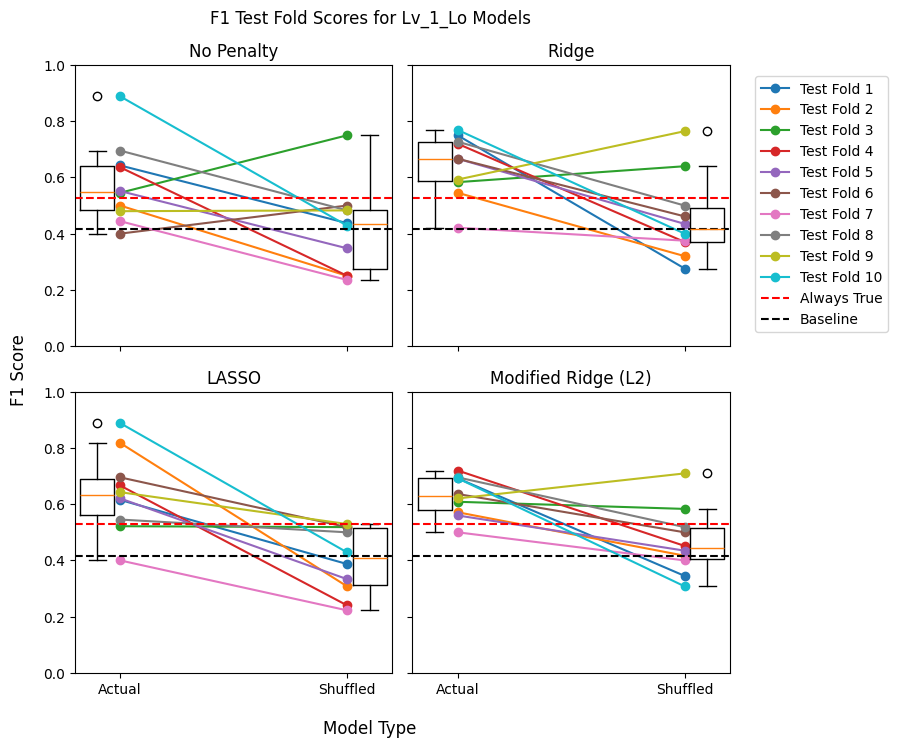

In [24]:
sensor_actual_vs_shuffled(f1_scores, outcomes_df, "Lv_1_Lo", "F1")

## Significance Tests

In [26]:
def actual_vs_shuffled_t_test(model_scores, lvl):
    print("Paired (Actual vs. Shuffled)")
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_rel(
            model_scores["Actual"][lvl][penalty],
            model_scores["Shuffled"][lvl][penalty]
        )
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')
    print()

In [27]:
actual_vs_shuffled_t_test(f1_scores, "Lv_1_Lo")

Paired (Actual vs. Shuffled)
Penalty                       t      p      
No Penalty                    2.476  0.035
Ridge                         3.022  0.014
Modified Ridge (L2)           3.615  0.006
LASSO                         4.384  0.002

